In [1]:
using PlotlyJS, DataStructures, NBInclude, LogExpFunctions, Distributions

run_examples = true

true

Mathemetical definitions are from https://en.xen.wiki/w/Harmonic_entropy.

# Harmonic Entropy (HE)

$$ HE(c) = H(J|c) = -\sum_{j \in J}{P(j|c)\log{P(j|c)}}, \quad j=\cfrac{n}{d} \in \mathbb{Q}; c \in [0; 1200] $$
where $J$ is Farey or Tenney `series` of order $N$ and
$$ P(j|c) = \cfrac{Q(j|c)}{\sum_{j \in J}{Q(j|c)}} $$
$$ Q(j|c) = \cfrac{S(¢(j)-c)}{\lVert j \rVert} $$
there are different `metrics` of simple fractions:  
$$ \lVert j \rVert = \sqrt{nd}  \quad \text{or} \quad  \lVert j \rVert = max(n, d) $$

In [84]:
function calcRatios(N::Int, series::String)
    J = []
    if series == "Tenney" # ratios are bounded by Tenney height
        for nNum in N:-1:1
            for i in 1:1:sqrt(nNum)+1
                if ((nNum % i == 0) && (gcd(Int(i), Int(div(nNum, i))) == 1))
                    k = div(nNum, i)
                    append!(J, Rational(Int(i), Int(k)))
                    if (k != i)
                        append!(J, Rational(Int(k), Int(i)))
                    end
                end
            end
        end
    elseif series == "Farey" # ratios are bounded by Weil height
        for nNum in N:-1:1
            for i in 1:nNum
                if gcd(i, nNum) == 1
                    append!(J, Rational(nNum, i))
                    if (nNum != i)
                        append!(J, Rational(i, nNum))
                    end
                end
            end
        end
    else
        error("Not valid series name")
    end

    return collect(J)
end


function ratio_metric(j::Rational, metric::String)
    if metric == "sqrt"
        return sqrt(numerator(j)*denominator(j))
    elseif metric == "max"
        return max(numerator(j),denominator(j))
    else
        error("Not valid metric name")
    end
end


function ratioToCents(r::Rational)
    return 1200*log2(Float64(r))
end


function HE(
        C::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64},
        N::Int, series::String, metric::String, σ::Float64)

    J = calcRatios(N, series)
        
    numJ = length(J)
    numC = length(C)

    Qs = zeros(numJ, numC)
    for j_ind in 1:numJ
        Qs[j_ind, :] .= pdf.(Normal(0, σ), ratioToCents(J[j_ind]) .- C)/ratio_metric(J[j_ind], metric)
    end
    Qsum = sum(Qs, dims=1)

    Ps = Qs./Qsum

    H = -sum(xlogy.(Ps, Ps), dims=1)

    return vec(H)
end

HE (generic function with 4 methods)

### Harmonic Entropy example

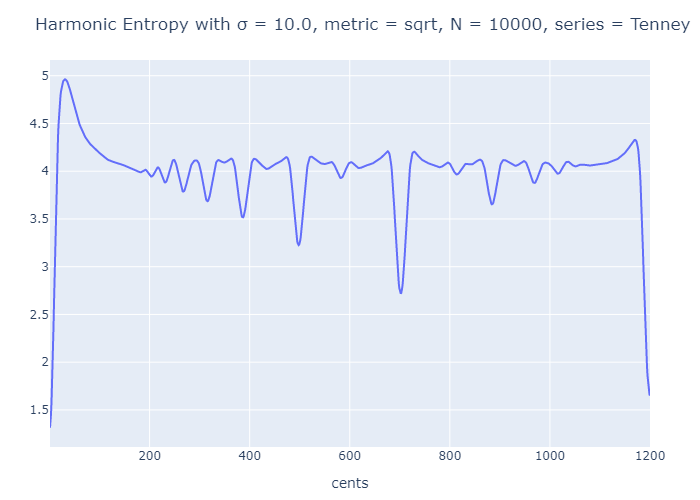

In [87]:
if run_examples
    σ = 10.
    metric = "sqrt" # "max" or "sqrt"
    N = 10000     #  100 - Farey or 10000 - Tenney
    series = "Tenney" # "Farey" or "Tenney"
    C = 1:1.0:1200

    layout = Layout(
        title="Harmonic Entropy with σ = $σ, metric = $metric, N = $N, series = $series",
        xaxis_title = "cents",
    )
    
    HE_arr = HE(C, N, series, metric, σ)
    p = plot(C, HE_arr, layout)
    display(p)
end

# Scale Harmonic Entropy (SHE)

Scale consists of notes (in ascending order): $\mathscr{N}=\{N_1, N_2, ..., N_n\}$, $N_i \in C = [0; 1200)$.
$$ SHE = \cfrac{2}{n(n+1)}\sum_{i = 1}^{n}{\sum_{j = i}^{n}{HE(N_j - N_i)}} $$

In [88]:
function SHE(
        C::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64},
        HE_arr::Vector{Float64}, notes::Vector{Float64})
    
    SHE_val = 0
    numNotes = length(notes)
    
    for i in 1:numNotes
        for j in i:numNotes
            SHE_val += HE_arr[argmin(abs.(C .- (notes[j] - notes[i])))]
        end
    end

    return SHE_val*2/(numNotes)/(numNotes+1)
end

SHE (generic function with 1 method)

### Scale Harmonic Entropy example

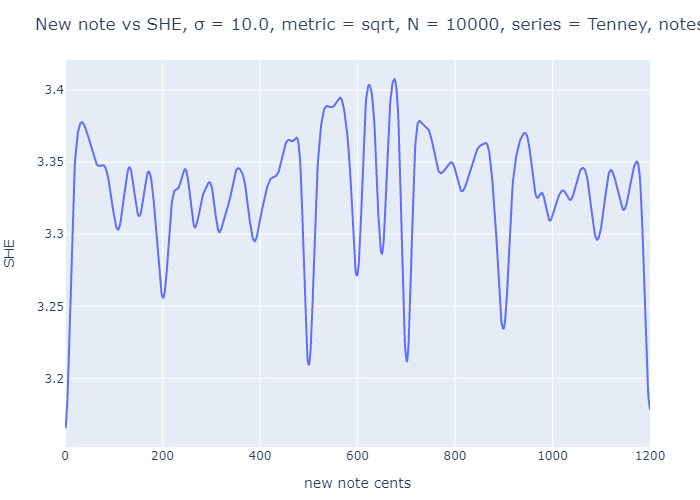

In [89]:
if run_examples
    σ = 10.
    metric = "sqrt" # "max" or "sqrt"
    N = 10000     #  100 - Farey or 10000 - Tenney
    series = "Tenney" # "Farey" or "Tenney"
    notes = [0., 500., 600., 650., 700., 900.]

    C = range(start=0, stop=1200, length=1201)
    HE_arr = HE(C, N, series, metric, σ)

    newNoteCents = range(start=0, stop=1200, length=1201)
    SHE_arr = zeros(length(newNoteCents))

    for i in range(1, length(newNoteCents))
        SHE_arr[i] = SHE(C, HE_arr, sort(vcat(notes, newNoteCents[i])))
    end

    p = plot(newNoteCents, SHE_arr, Layout(
        title = "New note vs SHE, σ = $σ, metric = $metric, N = $N, series = $series, notes = $notes",
        xaxis_title = "new note cents",
        yaxis_title = "SHE"
    ))
    display(p)
end